## Table of Content:
* [What is feature importance and feature selection importance](#first-bullet)
* [data](#data-bullet)
* [How to measure importance of a feature (2 categories)](#second-bullet)
    * Strategies applied directly to data
        * [Option 1: Spearman's Rank Correlation Coefficient](#option1)
        * [Option 2: Principle Component Analysis (PCA)](#option2)
        * [Option 3: Minimal-redundancy-maximal-relevance (mRMR)](#option3)
    * Strategies applied to models
        * [Option 4: Perumation importance](#option4)
        * [Option 5: drop column importance](#option5)
* [Stratgies Comparion for regression model](#fifth-bullet)
* [Stratgies Comparion for logistic model](#sixth-bullet)
* [Stratgies Comparion for XGBoost model](#seventh-bullet)
* [Auto Feature Selection](#auto-feature)
* [Variance and empirical p-values for feature importances](#pvalue)
* [Conclusion](#conclusion)
* [Reference](#reference)

## What is feature importance and feature selection importance  <a class="anchor" id="first-bullet"></a>


In a data set, we will typically experience facing a lot of data with a large number of features. Selecting which feature to be included in your model can be useful in many ways:
- It could **reduce the computation cost** since you would be 'neglecting' some of the unimportant features and thus improve calculation efficiency
- It could help **reduce the cost associated with data collection** since less is needed
- It could **improve interpretability** (the situation of "less is more")

## Data <a class="anchor" id="data-bullet"></a>

We will use boston data as our example through out this report. 

We will load boston data, split them into train and testing set then Normalize them.

**Dependent Variable**: 
- MEDV: Median value of owner-occupied homes in 1000's of dollars

**Explanatory Variables**:
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10,000 dollars
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of black residents by town
- LSTAT: lower status of the population

In [105]:
%run featimp

In [2]:
x_train, y_train, x_val, y_val = boston_data_processing()

## How to measure importance of a feature <a class="anchor" id="second-bullet"></a>

The question then becomes how can we best select the amount of features that can not only reduced the computation cost but also achieve the analytic objective (maximize the level of accuracy for example). There are many ways to conduct feature selection and it can be splitted them into two major categories: 

**Category 1: strategies applied directly to the data**
- Option 1: Spearman's Rank Correlation Coefficient
- Option 2: Principle Component Analysis (PCA)
- Option 3: Minimal-redundancy-maximal-relevance (mRMR)

**Stategy 2: strategies applied to the model**
- Option 4: Perumation importance
- Option 5: drop column importance

### Option 1: Spearman's Rank Correlation Coefficient <a class="anchor" id="option1"></a>

The Spearman correlation coefficient (similar to Pearson correlation) can take values from +1 to -1. -1 being perfect negative association of ranks, +1 being perfect postive association of ranks and 0 indicates no association between ranks. Unlike Pearson correlation, Spearman's **correlation coefficient measures the strength and direction of association between two ranked variables**.

As an example, if we want to know the feature ranking of a dataset and its target variable, we could apply Spearman correlation and draw feature importance ranking graph below:

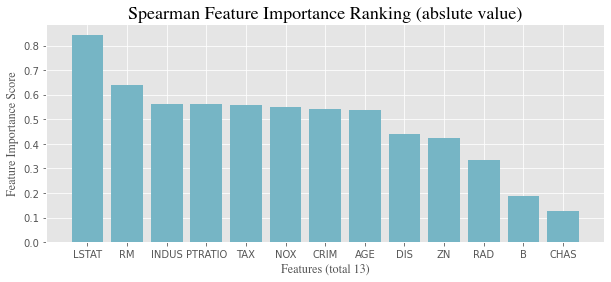

In [67]:
Spearman_rank = spearman(x_train, y_train, graph=True)

In [4]:
Spearman_rank

{'LSTAT': 0.8439505505721245,
 'RM': 0.6410064914926459,
 'INDUS': 0.5644198295412649,
 'PTRATIO': 0.564328752095172,
 'TAX': 0.5592417810966965,
 'NOX': 0.549104748593813,
 'CRIM': 0.5412368269843143,
 'AGE': 0.5391634662096841,
 'DIS': 0.4400458787762441,
 'ZN': 0.4255315746512831,
 'RAD': 0.33362117123869656,
 'B': 0.1875316028924484,
 'CHAS': 0.12534814425145807}

This graph indicates each feature's strength and direction association with the target variable (MEDV). LSTAT has the highest score which means this feature has the strongest positive direction with the target variable out of all other features.

### Option 2: Principle Component Analysis (PCA)<a class="anchor" id="option2"></a>

PCA is an unsupervised dimensionality reduction technique that is designed to reduce multidimensional features into a relevant set of features throught linear (or non-linear) combinations of the original variables(features). 

The construction of the relevant features is achieved by tranforming a set of linearly correlated variables to a set of uncorrelated variables, which is done by projecting the original data into the reduced PCA space, using eigenvector of the coranriance correlation matrix. 

Note: the first component explains the most variance with each subsequent components explaining less. So, we will only display the first component below.

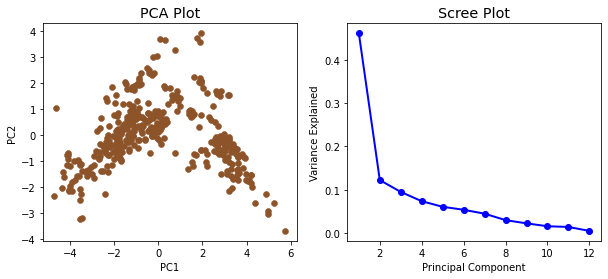

In [5]:
pca_rank, explained_variance = pca(x_train, graph=True) 

In [6]:
pca_rank

,DIS,AGE,CRIM,B,INDUS,PTRATIO,RM,NOX,CHAS,ZN,TAX,RAD
0,0.364934,0.363197,0.361225,0.343843,0.342518,0.325118,0.269884,0.261896,0.209787,0.209097,0.184274,0.007989


The table above is the feature ranking produced by PCA method

In [7]:
pc1 = explained_variance[0]
pc1

0.4614548018959607

From the PCA graph on the left we can visially se that PC1 explains more variance than PC2. The graph on the right indicates the percentage of variance can be explained as principle component increases. Since the max principle component can be min(n_samples, n_features), I plotted all to indicate how the % variance explained decreases as PC increases. 

### Option 3: Minimal-redundancy-maximal-relevance (mRMR) <a class="anchor" id="option3"></a>

As the name suggests, we want to find features that have maximimum relevancy with respect to the target variable but would also like to make sure the selected variables are not redundant. Specifically, the idea of MRMR is, through iteration, to find a score that measures a feature's performance on these two metrics(redudancy and relevancy), find the best score as the best feature (for that iteration). 

Difference between MRMR and Spearman's ranking or Boruta is that "K best features" is not the same idea as "best K features". In other words, certain features could be identified as "important" due to high (multi)collinearilty, but, in fact, can be dropped out of the training set without disturbing the result. MRMR is able to identify the best K features by excluding the information shared between codependent features. 

In [8]:
k = 13
mrmr_rank = mRMR(x_train, y_train, k)
mrmr_rank

100%|██████████| 13/13 [00:01<00:00,  7.52it/s]


['LSTAT',
 'CHAS',
 'CRIM',
 'RM',
 'AGE',
 'B',
 'PTRATIO',
 'NOX',
 'INDUS',
 'ZN',
 'TAX',
 'RAD',
 'DIS']

The only thing that needs to be decided for mRMR is how many k features we want to keep. In this example, we selected 9 features, and the list above is the result of feature ranking by mRMR method. 

To compare the startegies applied on the boston dataset so far, we see that different methods produce different ranking of feature importance. 

In [9]:
spearman_rank = list(Spearman_rank.keys())
pca_rank  = list(pca_rank.columns) + ['NA']
mrmr_rank = mrmr_rank
pd.DataFrame({'Spearman': spearman_rank, 'PCA':pca_rank, 'mRMR': mrmr_rank})

,Spearman,PCA,mRMR
0,LSTAT,DIS,LSTAT
1,RM,AGE,CHAS
2,INDUS,CRIM,CRIM
3,PTRATIO,B,RM
4,TAX,INDUS,AGE
5,NOX,PTRATIO,B
6,CRIM,RM,PTRATIO
7,AGE,NOX,NOX
8,DIS,CHAS,INDUS
9,ZN,ZN,ZN


### Option 4: Permutation Importance (model based) <a class="anchor" id="option4"></a>

Permutation Importance strategy helps us identify features that have the biggest impact on the predictions. One thing to note is that permucation feature importance is calculated after a model has been fitted.

What we did here is randomly shuffle a single column of the validation data, leaving the target and other columns unchanged and see how this shuffling impact the accuracy of the prediction in that shuffled data. 

since this measurement is taken after a model is been fitted, we will first fit a model (using linear regression method). 

MAE:  0.355396426488846


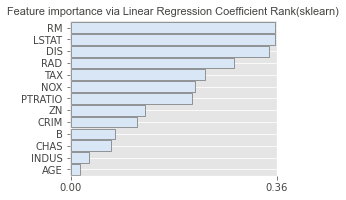

In [10]:
reg = fit_linear_regression_model(x_train, y_train, x_val, y_val)

now let's deploy the permutation importance and re-calculate the feature importance scrore. Here we are using **permutation_importance function from sklearn.inspection package**.

for parameter "scoring": we have following 3 options:
- 'r2', 
- 'neg_mean_absolute_percentage_error'
- 'neg_mean_squared_error'

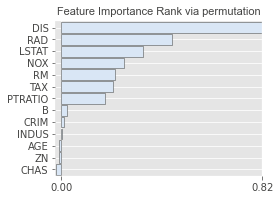

In [11]:
chart = eval_metrics(reg, x_val, y_val, 'neg_mean_absolute_percentage_error', graph=True)

Comparing feature imporant graph before and after we applied permutation method, we can see that the ranking has changed. LSTAT is now the 4th most import feature in relative to the target variable (it was first before permutation method was applied)

applying different metric will also provide different ranking of the features. Therefore, depends on the dataset we are working with, we should evaluate which metric makes most sense to be used throughout analysis. For example, if we know the data is very noisy, MAE might be a better option than MSE.

In [12]:
eval_metrics(reg, x_val, y_val, 'neg_mean_squared_error', graph=False).head(5)

,features,imp_mean +- std
0,LSTAT,0.264 +/- 0.048
1,DIS,0.212 +/- 0.053
2,NOX,0.121 +/- 0.031
3,RM,0.116 +/- 0.035
4,RAD,0.115 +/- 0.041


In [13]:
eval_metrics(reg, x_val, y_val, 'r2', graph=False).head(5)

,features,imp_mean +- std
0,LSTAT,0.301 +/- 0.054
1,DIS,0.242 +/- 0.060
2,NOX,0.138 +/- 0.035
3,RM,0.133 +/- 0.040
4,RAD,0.130 +/- 0.047


### Option 5: Drop Column Importance (model based) <a class="anchor" id="option5"></a>

Another method to identify feature importance through the model is known as drop column importance. The idea behind this method is once you have a baseline metric (we are using MAE throughout the report), we will drop features one at a time (through iternation). Once a column is dropped, we will re-fit the model with the new x_train, predict the target variable and re-calculate a new metric. We will then deduct the new metric from the baseline to see how big the difference is. The larger the difference is, the more important this dropped feature is to the model. 

In [14]:
dropcol_rank = dropcol_regression(reg, x_train, y_train, x_val, y_val)
dropcol_rank

,Importance
Feature,
PTRATIO,0.041052
LSTAT,0.033513
B,0.011606
RAD,0.010557
CRIM,0.006969
TAX,0.006326
NOX,0.005978
ZN,0.005918
RM,0.002947


Now let's compare the feature ranking between the model based strategies:

In [15]:
permutation_rank = chart[0].features.tolist()
dropcol_rank = dropcol_rank.index.tolist()
pd.DataFrame(data={'Permutation':permutation_rank, 'drop_col':dropcol_rank})

,Permutation,drop_col
0,DIS,PTRATIO
1,RAD,LSTAT
2,LSTAT,B
3,NOX,RAD
4,RM,CRIM
5,TAX,TAX
6,PTRATIO,NOX
7,B,ZN
8,CRIM,RM
9,INDUS,DIS


### Strategies Comparison

We have now listed 5 ways of identifying feature importance, either through understanding the data directly or do something with the model. Next step is to understand for different model (regression, random forest and XGboost, which method of feature selection is the most appropriate).

Following functions are made to a) initiate a model, 2) iteract through each and every feature for each feature selection methods (total 5), 3) drop one column at a time to come up with a new training set; 4) refit the model with new training set and 5) predict the target value and calculate a new MAE score. 

The drop in the metric MAE score indicates an improvement of the model performance by simplying having more features (or vice versa, the increase of metric score indicates the model gets worse when more features are dropped). 

- linear_regression_best_feaimp()
- rf_regression_best_feaimp()
- xgboost_best_feaimp

#### Regression Model <a class="anchor" id="fifth-bullet"></a>

In [30]:
mae = linear_regression_best_feaimp(x_train, y_train, x_val, y_val, k=13)

100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


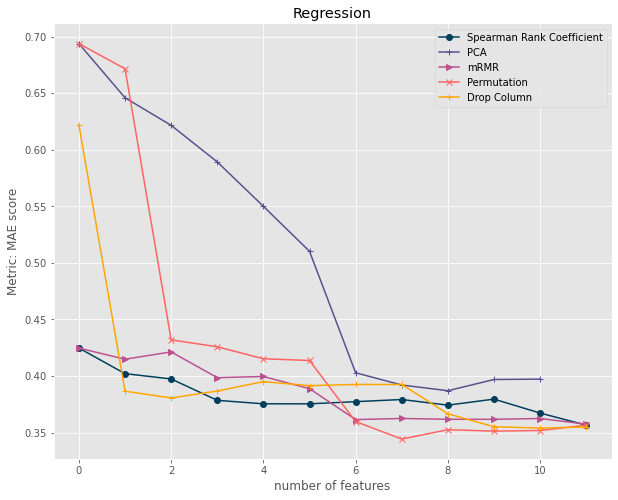

In [31]:
plot_comparison(mae, 'Regression')

#### Random Forest Model <a class="anchor" id="sixth-bullet"></a>

In [37]:
mae = rf_regression_best_feaimp(x_train, y_train, x_val, y_val, k=13)

100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


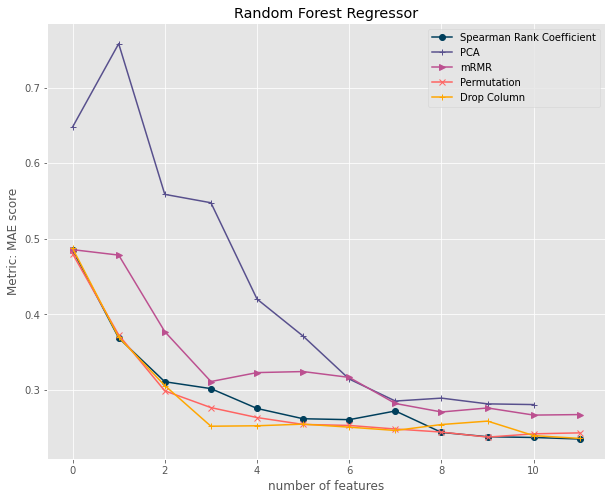

In [38]:
plot_comparison(mae, 'Random Forest Regressor')

#### XGBoost Model <a class="anchor" id="seventh-bullet"></a>

In [41]:
mae = xgboost_best_feaimp(x_train, y_train, x_val, y_val, k=13)

100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


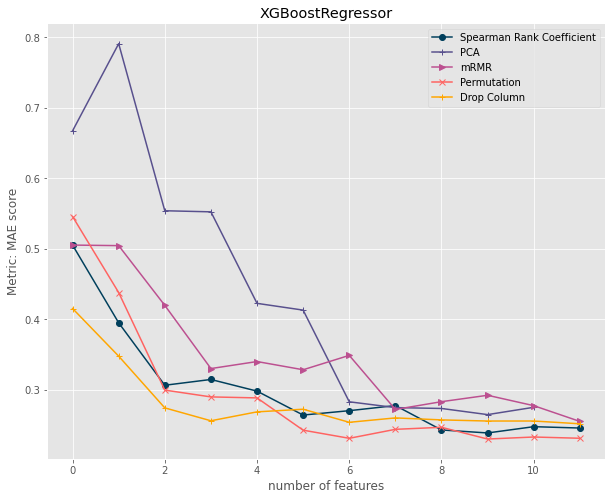

In [42]:
plot_comparison(mae, 'XGBoostRegressor')

For illustration purpose, I chose linear regression, RandomForestRegressor and XGBoostRegressor model to text on 5 methods we identified to select features. From the graphs above we can see that:
- The more feature included in the graph, the better the MAE score gets
- Different model may prefer different methods of feature selection to achieve the best performance
- Depending on how many features we want to keep, the feature selection method might be different

Now we will develop an algorithm which can automatically select feature selection method (5 methods identified earlier) based on the model that is provided:

### Auto Feature Selection <a class="anchor" id="auto-feature"></a>


For instance, let's see what the feature selection method the algorithm will pick given the model and number of features we want to keep. We will demonstrate 3 models seperately here

In [85]:
reg = LinearRegression()
rf = RandomForestRegressor()
xgboost = XGBRegressor()
k = 4

#### For Linear Regression Model

100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


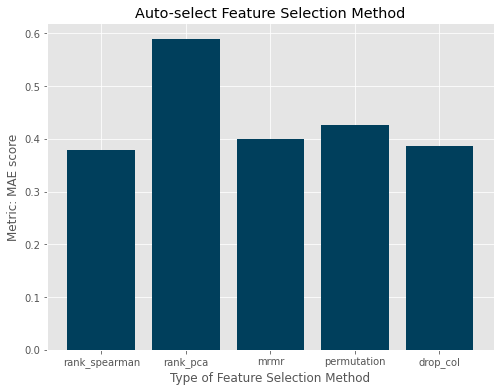

In [76]:
scores, best_method, model, features = auto_select(reg, x_train, y_train, x_val, y_val, k)

In [77]:
print(f'The best feature selection method is {best_method} and top {k} features selected by this method is: {features}')

The best feature selection method is rank_spearman and top 4 features selected by this method is: ['LSTAT', 'RM', 'INDUS', 'PTRATIO']


#### For Random Forest Model

100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


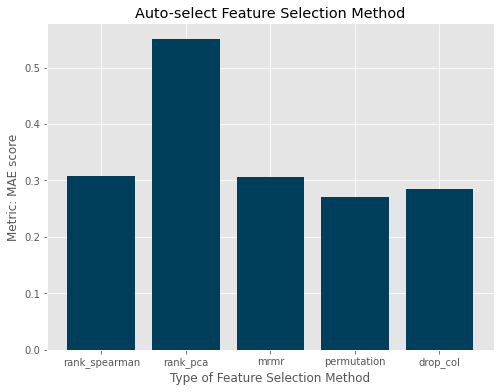

In [99]:
scores, best_method, model, features = auto_select(rf, x_train, y_train, x_val, y_val, k)

In [100]:
features

['RM', 'LSTAT', 'DIS', 'CRIM']

#### For XGBoostRegreesor Model

100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


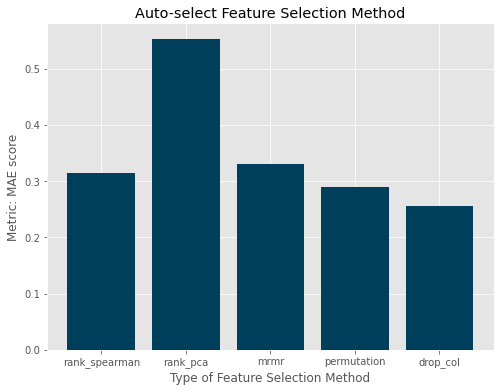

In [86]:
scores, best_method, model, features = auto_select(xgboost, x_train, y_train, x_val, y_val, k)

In [96]:
features

['NOX', 'RM', 'LSTAT', 'RAD']

From the auto_selection function we can tell, for k=4, PCA is the best feature selection method for linear regression model, drop column is the best method for RandomForestRegressor and XGBoostRegressor model. This will change again when we change value for k. However, this function will allow us to detect which method to use once we have an idea of how many features we want to keep.

We could also use shap to see how features contributed to the xgboost model we just trained above, where k = 4.

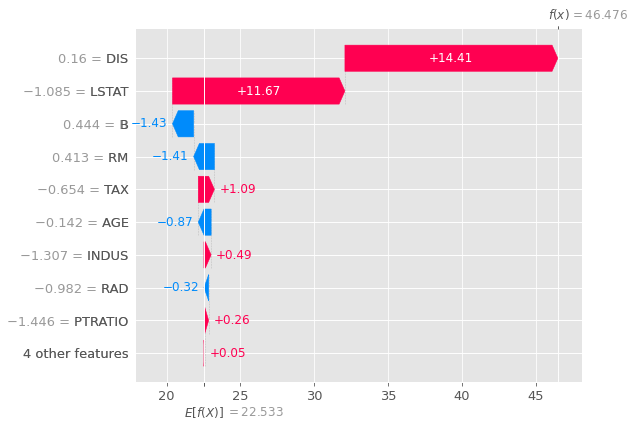

In [88]:
X, y = shap.datasets.boston()
xgboost = model.fit(X, y)

explainer = shap.Explainer(xgboost)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

We see that feature DIS contributed the most to the target variable and LSTAT follows the next. The average model output over the training dataset we passed is around 22.5.

### Variance and empirical p-values for feature importances <a class="anchor" id="pvalue"></a>


Now we will calculate the p-values for feature importance (xgboostregressor model)

In [107]:
actual_imp_df = get_feature_importances(x_train, y_train, x_val, y_val)
actual_imp_df

,feature,importance_gain,importance_split,MAE_loss
0,CRIM,322.945435,554.0,0.246321
1,ZN,0.979139,21.0,0.246321
2,INDUS,19.895899,171.0,0.246321
3,CHAS,1.583385,24.0,0.246321
4,NOX,69.001320,267.0,0.246321
5,RM,3971.218750,592.0,0.246321
6,AGE,100.732727,324.0,0.246321
7,DIS,374.478302,387.0,0.246321
8,RAD,6.605189,69.0,0.246321
9,TAX,50.628292,137.0,0.246321


In [108]:
null_imp_df = null_imp_df(x_train, y_train, x_val, y_val)
null_imp_df

,feature,importance_gain,importance_split,MAE_loss,run
0,CRIM,916.596619,810.0,0.867254,1
1,ZN,54.172356,55.0,0.867254,1
2,INDUS,364.177917,167.0,0.867254,1
3,CHAS,12.302530,4.0,0.867254,1
4,NOX,352.383209,217.0,0.867254,1
...,...,...,...,...,...
8,RAD,53.533817,46.0,0.819814,80
9,TAX,225.612823,94.0,0.819814,80
10,PTRATIO,127.585991,94.0,0.819814,80
11,B,687.561523,414.0,0.819814,80


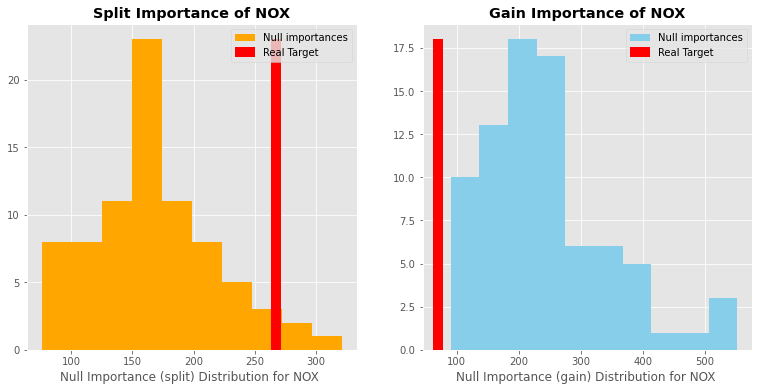

In [110]:
display_distributions(actual_imp_df, null_imp_df, 'NOX')

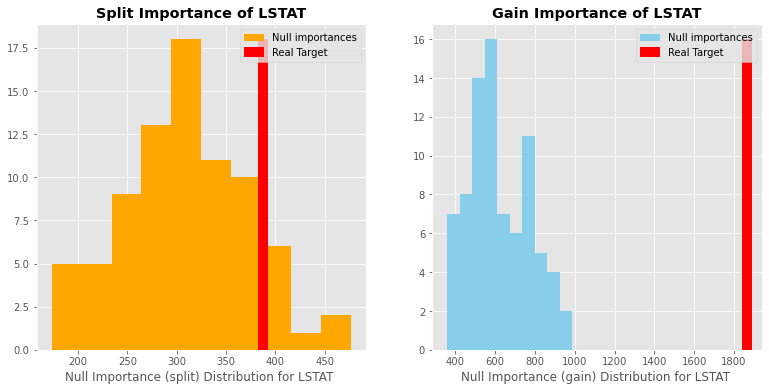

In [111]:
display_distributions(actual_imp_df, null_imp_df, 'LSTAT')

### Conclusion <a class="anchor" id="conclusion"></a>

Feature selection can be critical for us to produce a good and efficient model. Depending on the type of program we are solving, we will deploy different models and therefore adapt different types of feature selection methods. 

We built a function where we can compare different type of feature selection methods and select the best one based on the metric of interest (MAE). We also built an auto selection algorithm where we can select which method of feature selection is most efficient given a model and a number of features we want to keep. 

In the end, we used p-value to evaluate whether a feature is truely significant to the model by shuffling the target variable y, and then compute the feature importances again (first normalize the feature importances). If the total count of how many times a feature is as important or more important than the true feature importance computed as a baseline, then it is a significant feature to be kept in the model. Couple examples were shown above.

### Reference <a class="anchor" id="reference"></a>

https://github.com/slundberg/shap

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

https://explained.ai/rf-importance/index.html